# Practical Motivation

Reddit is a social news website and forum that is extremely popular in the US. The forum pages on reddit are known as subreddit pages. Wallstreetbets is a popular subreddit page where people discuss about stocks and investments. They mainly discuss about stocks on the US market.

For this project we will be looking at the following: 

Problem Definition

> Can we predict stock prices with online comments/trends on social media?

Solution Approach
> By using classification model to check whether r/wallstreetbets post there can dedicate stock prices.



In [2]:
!pip install yfinance

# Import

In [3]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np 
import pandas as pd 
from collections import Counter
from tqdm import tqdm

import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kelvi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


---

# 1. Data Extraction



## 1.1 Reddit data from the subreddit wallstreetbets retrieved from kaggle

> Gabriel Preda. (2021). <i>Reddit WallStreetBets Posts</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/2530155

In [5]:
df = pd.read_csv('reddit_wsb.csv', parse_dates = ['timestamp'], infer_datetime_format=True)

In [6]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [7]:
df.describe()

,score,comms_num,created
count,53187.000000,53187.000000,5.318700e+04
mean,1382.461053,263.260252,1.614582e+09
std,7999.271074,2532.665113,4.173566e+06
min,0.000000,0.000000,1.601340e+09
25%,2.000000,3.000000,1.611882e+09
50%,37.000000,17.000000,1.612488e+09
75%,207.000000,60.000000,1.615347e+09
max,348241.000000,93268.000000,1.629095e+09


## 1.2 Getting stock tickers
> Getting all US listed stock tickers from major markets

In [8]:
us_stocks =pd.read_csv('nasdaq_screener.csv')
us_stocks.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$123.34,-1.9500,-1.556%,3.701598e+10,United States,1999.0,495793,Capital Goods,Electrical Products
1,AA,Alcoa Corporation Common Stock,$68.1459,-4.0541,-5.615%,1.256752e+10,NaN,2016.0,4922181,Basic Industries,Metal Fabrications
2,AAL,American Airlines Group Inc. Common Stock,$20.445,0.2250,1.113%,1.327208e+10,United States,NaN,19716727,Transportation,Air Freight/Delivery Services
3,AAON,AAON Inc. Common Stock,$56.11,-0.1300,-0.231%,2.949731e+09,United States,NaN,41670,Capital Goods,Industrial Machinery/Components
4,AAP,Advance Auto Parts Inc.,$220.53,-5.0300,-2.23%,1.347243e+10,United States,NaN,78007,Consumer Services,Other Specialty Stores


In [9]:
us_tickers = set(us_stocks["Symbol"])

---

# 2. Data Preparation and Data Cleaning
> To prepare the data for analysis, it is crucial to make sure the data is 'clean'. Only then can the analysis be accurate and error-free. In addition, clean data is a crucial element of training a sentiment classifier, since its accuracy is completely dependent upon it. An incorrect, duplicate, or contradictory sentiment classifier will be developed if it is trained on incorrect, duplicate, or contradictory data.

## 2.1 Drop all empty rows with title that is empty


In [10]:
df.dropna(subset = ['title'], inplace = True) 

## 2.2 Fill body column's NaN values with empty string

In [11]:
df['body'] = df['body'].fillna('')

## 2.3 Combine **title** and **body** to form **full_text**


In [12]:
df['full_text'] = df['title'] + ' ' + df['body'].fillna('') #NA values fill with empty string

## 2.4 Count words for title and body

In [13]:
def word_count(text):
  return len(re.findall(r'\w+', text))

df["wordcount_full_text"] = df["full_text"].apply(word_count)


## 2.5  Extract stocks from full_text 

> This process has to be done before cleaning as cleaning might remove stock names. Compare **full_text** against a set **us_tickers** and **blacklist**. Finally the stocks found are inserted into dataframe under the *stocks* column 


In [14]:
from tqdm import tqdm

# includes common words and words used on wsb that are also stock names
blacklist_words = {'I', 'ELON', 'WSB', 'THE', 'A', 'ROPE', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR','DEC', 'BE', 'IMO', 'ALL', 'RH', 'EV', 'TOS', 'CFO', 'CTO', 'DD', 'BTFD', 'WSB', 'OK', 'PDT', 'RH', 'KYS', 'FD', 'TYS', 'US', 'USA', 'IT', 'ATH', 'RIP', 'BMW', 'GDP', 'OTM', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PR', 'PRAY', 'PT', 'FBI', 'SEC', 'GOD', 'NOT', 'POS', 'FOMO', 'TL;DR', 'EDIT', 'STILL', 'WTF', 'RAW', 'PM', 'LMAO', 'LMFAO', 'ROFL', 'EZ', 'RED', 'BEZOS', 'TICK', 'IS', 'PM', 'LPT', 'GOAT', 'FL', 'CA', 'IL', 'MACD', 'HQ', 'OP', 'PS', 'AH', 'TL', 'JAN', 'FEB', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'FDA', 'IV', 'ER', 'IPO', 'MILF', 'BUT', 'SSN', 'FIFA', 'USD', 'CPU', 'AT', 'GG', 'MAR'}

nlp = spacy.load("en_core_web_sm", disable=['parser'])
def is_stock(token):
  return ((token.is_upper)&(token.pos_=='PROPN')&(
  1<len(token.text)<=5)&(token.ent_type_ in ['','ORG','PERSON'])&(token.is_stop==False) & (token.text in us_tickers) & (token.text not in blacklist_words))
docs = list(nlp.pipe(df.full_text))
stock_docs = [[token.text for token in doc if is_stock(token)] for doc in tqdm(docs)]
del docs


100%|██████████████████████████████████████████████████████████████████████████| 53187/53187 [00:12<00:00, 4116.63it/s]


In [15]:
from collections import Counter
n_head= 20
stock_count = pd.DataFrame.from_dict(
    dict(Counter(
        [stock for stock_list in map(set, stock_docs) for stock in stock_list]
    )), orient='index'
).reset_index()
stock_count.rename(columns={'index':'stock',0:'count'},inplace=True)

stock_count = stock_count[stock_count['count']>10]

def filter_by_list(stdocs:list, sl:list):
    return [[stock.upper() for stock in los if stock in sl] for los in stdocs]

stock_list = stock_count[stock_count['count']>30].stock.to_list()

df['stocks'] = list(map(set,filter_by_list(stock_docs, stock_list)))



## 2.6 Remove new line (\n) and subreddit (\r) 


In [16]:
df['full_text'] = df['full_text'].replace(r'\n',' ', regex=True) 
df['full_text'] = df['full_text'].replace(r'\r',' ', regex=True) 

## 2.7 Remove links

In [17]:
def remove_links(text):
  return re.sub(r'http\S+', '', text)

df['full_text'] = df['full_text'].apply(remove_links)

## 2.8 Make all characters lower case

In [18]:
df['full_text'] = df['full_text'].str.lower()

## 2.9 Remove Punctuation

In [19]:
df['full_text'] = df['full_text'].str.replace('[^\w\s]','')

## 2.10 Remove emoji's

In [20]:
df['full_text'] = df['full_text'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

pd.set_option("display.max_colwidth", -1)

## 2.11 Remove stopwords
> Some words do not contribute much to the machine learning model, so it's good to remove them. We use the stopwords found from the nltk library 

In [21]:
# NLTK Stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from nltk.corpus import stopwords
def remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

df['full_text'] = df['full_text'].apply(remove_stop_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kelvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.12 Lemmatization
> Lemmatization converts the word into its root/base form, which is called Lemma. It also
considers the context of the word and what part of speech a word belongs to. Lemmatizing a
word as an adjective is going to differ than a verb. Take for example, the word “changing” if
lemmatized as an adjective it would remain the same.

In [22]:
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

df['full_text'] = df['full_text'].apply(lemmatize)

## 2.13 Remove posts outside stipulated timeframe

> There was a random post that happen in september 2020 and it was the only standalone post for that year. Hence we drop the row since it might affect the data

In [23]:
df = df[~(df['timestamp'] < '2021-01-28 21:37:41')]

## 2.14 Remove NAN/Empty values from full_text
> After cleaning there might rows of full_text that is empty. Remove them.

In [24]:
(df['full_text'].values == '').sum()

102

In [25]:
# Replace Empty String with NAN Values
df['full_text'].replace('', np.nan, inplace=True)
# drop all NAN values
df.dropna(subset=['full_text'], inplace=True)

In [26]:
df.isnull().sum()

title                  0
score                  0
id                     0
url                    0
comms_num              0
created                0
body                   0
timestamp              0
full_text              0
wordcount_full_text    0
stocks                 0
dtype: int64

## 2.15 Calculating sentiment scores
> The sentiment classifier VADER, which stands for Valence Aware Dictionary and Sentiment Reasoner, was used in this project. It was chosen because it not only measures sentiment polarity (positive/negative), but also sentiment intensity.   


In [27]:
#Vocab/slangs used in /r wallstreetbets that have special meaning hence we have tweak the scores given to them
#domain experts
new_words = {
     
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
     'overvalued': -3.0,
     'undervalued': 3.0,
     'buy': 4.0,
     'sell': -4.0,
     'bullish': 3.7,
     'bearish': -3.7,
     'bagholder': -1.7,
     'stonk': 1.9,
     'green': 1.9,
     'rocket': 2.2,
     'bull': 2.9,
     'bear': -2.9,
     'downgrade': -3.0,
     'upgrade': 3.0,     
     'pump': 1.9,
     'drop': -2.5,
     'rebound': 1.5,  
     }

sid = SentimentIntensityAnalyzer()

def VaderSentiment(text: str):
        sid.lexicon.update(new_words)
        d = sid.polarity_scores(text)
        return d['pos'],d['neu'],d['neg'],d['compound']



p = df.full_text.transform(VaderSentiment).to_list()
df[['VS_pos','VS_neu','VS_neg','compound']] = pd.DataFrame(p, columns=['VS_pos','VS_neu','VS_neg','compound'])
df['sentiment'] = df['compound'].apply(lambda c: 'pos' if c>0.1 else 'neg' if c<-0.1 else 'neu')
 

---

# 3. Exploratory Data Analysis (EDA)

> After doing the data cleaning on the dataset, we proceeded to work on Exploratory Data Analysis with our "cleaned" dataset. 
>
> We did some initial investigations on the data to discover patterns and spot anomalies with the help of statistics and graphical representations.


## 3.1 Wordcloud

> We decided to use a word cloud to highlight the top 20 words based on the frequency that it was mentioned through the reddit posts in our 'full_text' column. 
>
> As you can see there are several mentions of stocks such as GME and many other wallstreetbets terms. 
>
>For visual purpose only.

In [28]:
# For wordcloud lib
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [29]:
wcfull_text = " ".join(review for review in df.full_text.astype(str))

There are 19717726 words in the combination of all cells in full_text.


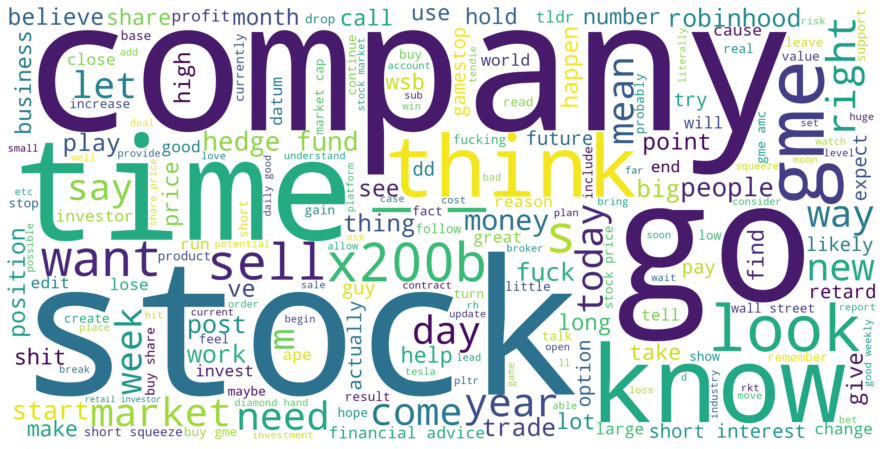

In [30]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(wcfull_text)

print ("There are {} words in the combination of all cells in full_text.".format(len(wcfull_text)))
wordcloud = WordCloud(background_color="white", width=2400, height=1200).generate(wcfull_text)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## 3.2 Distribution of fullcount_text

> We are trying to plot out a graph to see the distribution of word count in the full_text column.


In [31]:
df["wordcount_fulltext"] = df["full_text"].apply(lambda x: len(str(x).split(' ')))
wordcount_fulltext = pd.DataFrame(df["wordcount_fulltext"])
wordcount_fulltext

,wordcount_fulltext
0,5
258,39
259,13
260,7
261,3
...,...
53182,551
53183,137
53184,4
53185,160


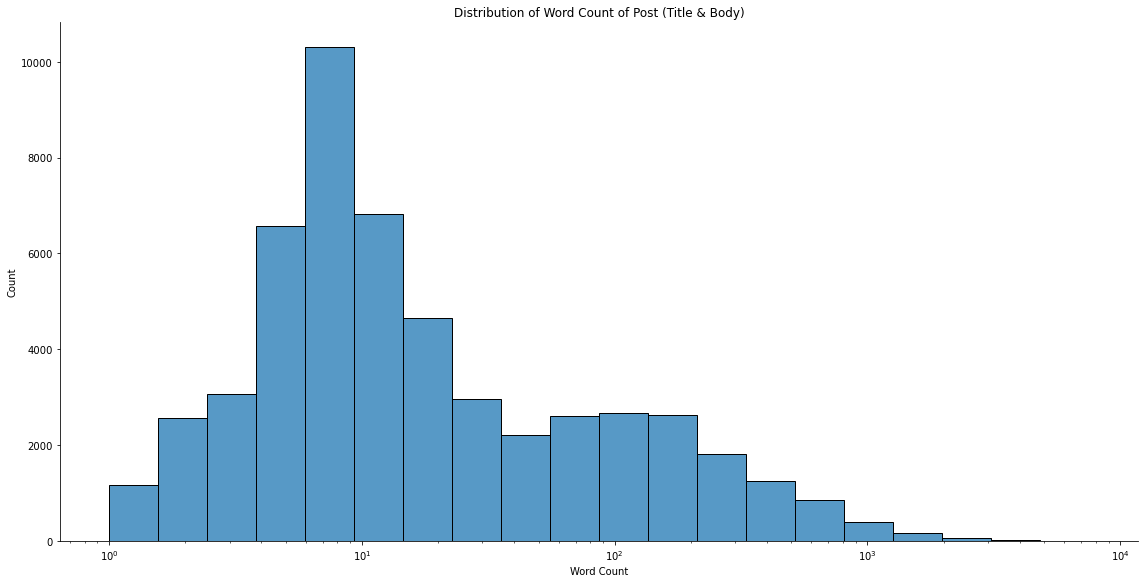

In [32]:
# Histogram 
sns.displot(data=df, kind="hist", x='wordcount_fulltext', height=8, aspect= 2, bins = 20, log_scale=True) # can include bins
plt.title("Distribution of Word Count of Post (Title & Body)")
plt.xlabel("Word Count")
plt.ylabel("Count") 
plt.show()


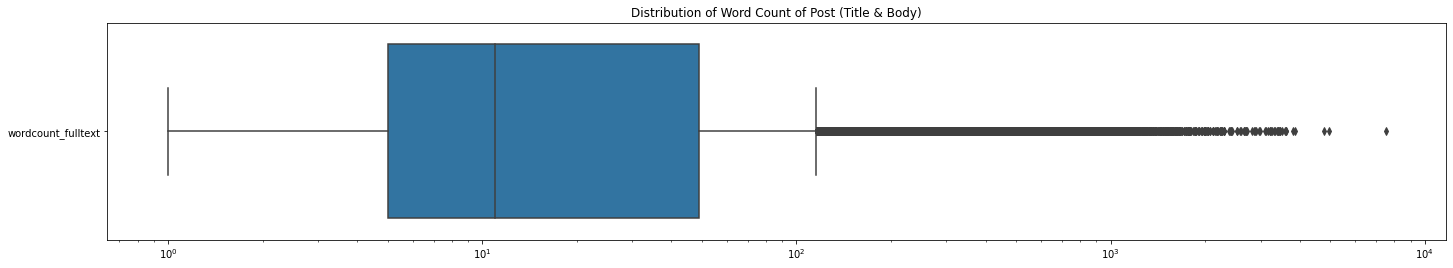

In [33]:
# Boxplot
f = plt.figure(figsize=(24,4))
sns.boxplot(data = wordcount_fulltext, orient = "h")
plt.title("Distribution of Word Count of Post (Title & Body)")
plt.autoscale(True)
plt.xscale('log')
plt.show()


## 3.3 Distribution of Post throughout the week

> We plotted out the distribution of posts by month, days of the week and hours of the day to see if we can see any trends in relation to it.

### 3.3.1 Distribution by Month

In [34]:
mon = pd.DataFrame(df['timestamp'])

mon['month'] = pd.to_datetime(mon.timestamp, format='%Y-%m-%d %H:%M:%S')
mon['month'] = mon['month'].dt.month_name()

mon.describe()


,timestamp,month
count,52827,52827
unique,43145,8
top,2021-01-29 01:03:59,January
freq,14,18959
first,2021-01-28 21:37:41,NaN
last,2021-08-16 09:26:20,NaN


In [35]:
mon['month'].replace('', np.nan, inplace=True)
mon.isnull().sum()

timestamp    0
month        0
dtype: int64

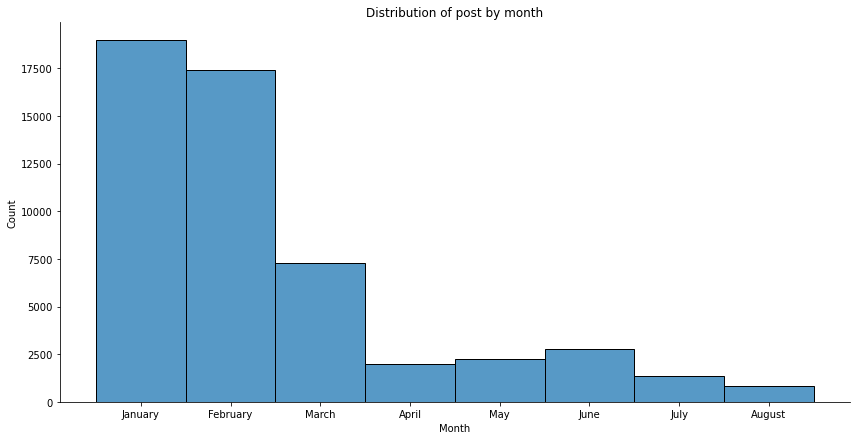

In [36]:
sns.displot(data=mon, kind="hist", x='month', height=6, aspect= 2)

plt.title("Distribution of post by month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()


Observation: r/WSB saw a huge amount of post during Q1 of the year.

### 3.3.2 Distribution by Day

In [37]:
day = pd.DataFrame(df['timestamp'])

day['day'] = pd.to_datetime(day.timestamp, format='%Y-%m-%d %H:%M:%S')
day['day'] = day['day'].dt.day_name()
day['day'] = pd.Categorical(day['day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

day.describe()


,timestamp,day
count,52827,52827
unique,43145,7
top,2021-01-29 01:03:59,Friday
freq,14,22472
first,2021-01-28 21:37:41,NaN
last,2021-08-16 09:26:20,NaN


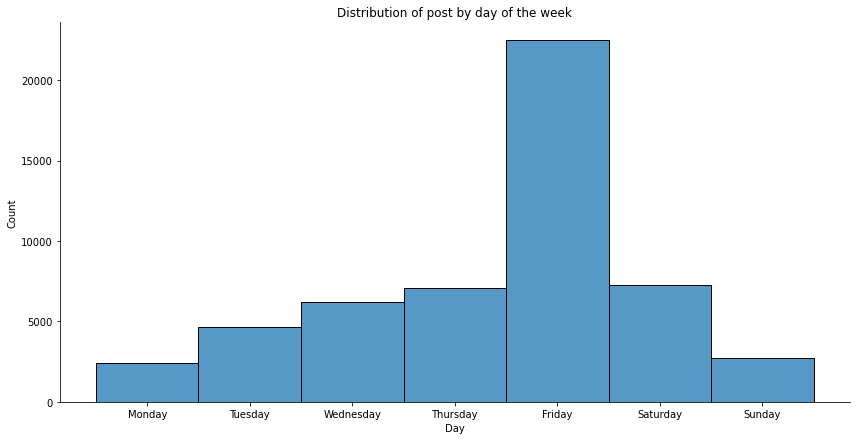

In [38]:
sns.displot(data=day, kind="hist", x='day', height=6, aspect= 2)

plt.title("Distribution of post by day of the week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()


Observation: Friday see the most number of post on r/WSB by a substantial amount

### 3.3.3 Distribution by Hour

> Based on EDT time (timing used for US market), US market opening hours between  Monday through Friday, 9:30 a.m. to 4:00 p.m.
>
> **Note**: Kaggle author made used of praw's post.created function to extract timestamp, which are in UTC+8 format
>
> UTC+8 is 12 hours ahead of EDT time
>
> Timing has been converted to EDT time

In [39]:
hour = pd.DataFrame(df['timestamp'])

hour['hour'] = pd.to_datetime(hour.timestamp, format='%Y-%m-%d %H:%M:%S')
hour['hour'] = hour['hour'].dt.hour
hour['hour'] = (hour['hour']+12)%24
hour.describe()


,hour
count,52827.000000
mean,13.200428
std,5.594607
min,0.000000
25%,12.000000
50%,14.000000
75%,16.000000
max,23.000000


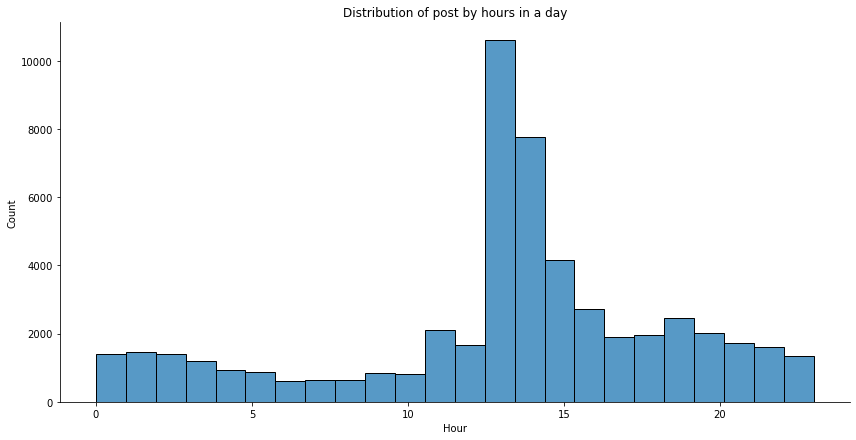

In [40]:
sns.displot(data=hour, kind="hist", x='hour', height=6, aspect=2, bins=24)

plt.title("Distribution of post by hours in a day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()


Observation: Most number of posts were made between 1300-1500h. It could be infer that the reason for it is because it is during lunch time in US, hence more people have time to make a post and interact on r/WallStreetBets.

## 3.4 Distribution of Score

> We understand that each post has a score (number of "likes"), we plotted score against count.
>
> **Note**: Data for distribution of score is heavily left skewed and we utilised a log transformation. As some posts contains 0 upvotes (likes), we did a log(x+1) transformation on the whole dataset.

In [41]:
score = pd.DataFrame(df['score'])

score += 1 # log(x+1) transformation

score.describe()

,score
count,52827.000000
mean,1363.864217
std,7913.344734
min,1.000000
25%,3.000000
50%,38.000000
75%,206.000000
max,348242.000000


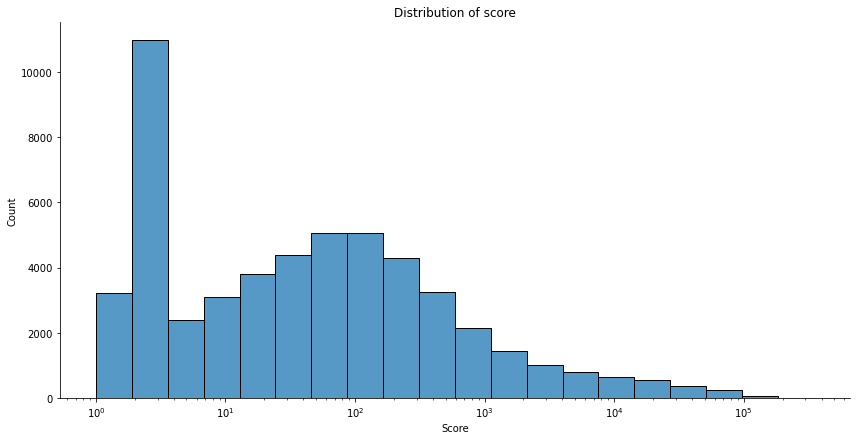

In [42]:
sns.displot(data=score, kind="hist", x='score', height=6, aspect= 2, bins=20, log_scale=True) # can include bins

plt.title("Distribution of score")
plt.xlabel("Score")
plt.ylabel("Count") 
plt.show()


## 3.5 Correlation for Numeric Data

> We look at correlation between numeric data
>
> **score**: Number of likes of the post
>
> **comms_num**: Number of comments on the post
>
> **wordcount_fulltext**: Word count, for both title and body
>
> **compound**: compounded sentimental score of each post

In [43]:
num_data = pd.DataFrame(df[["score", "comms_num", "wordcount_fulltext", "compound"]])
num_data.describe().round(2)

,score,comms_num,wordcount_fulltext,compound
count,52827.00,52827.00,52827.00,52467.00
mean,1362.86,261.65,71.59,0.21
std,7913.34,2526.63,194.25,0.60
min,0.00,0.00,1.00,-1.00
25%,2.00,3.00,5.00,-0.15
50%,37.00,17.00,11.00,0.27
75%,205.00,59.00,49.00,0.76
max,348241.00,93268.00,7493.00,1.00


                       score  comms_num  wordcount_fulltext  compound
score               1.000000  0.187668  -0.015508            0.012260
comms_num           0.187668  1.000000   0.018003            0.014029
wordcount_fulltext -0.015508  0.018003   1.000000            0.033429
compound            0.012260  0.014029   0.033429            1.000000


<AxesSubplot:>

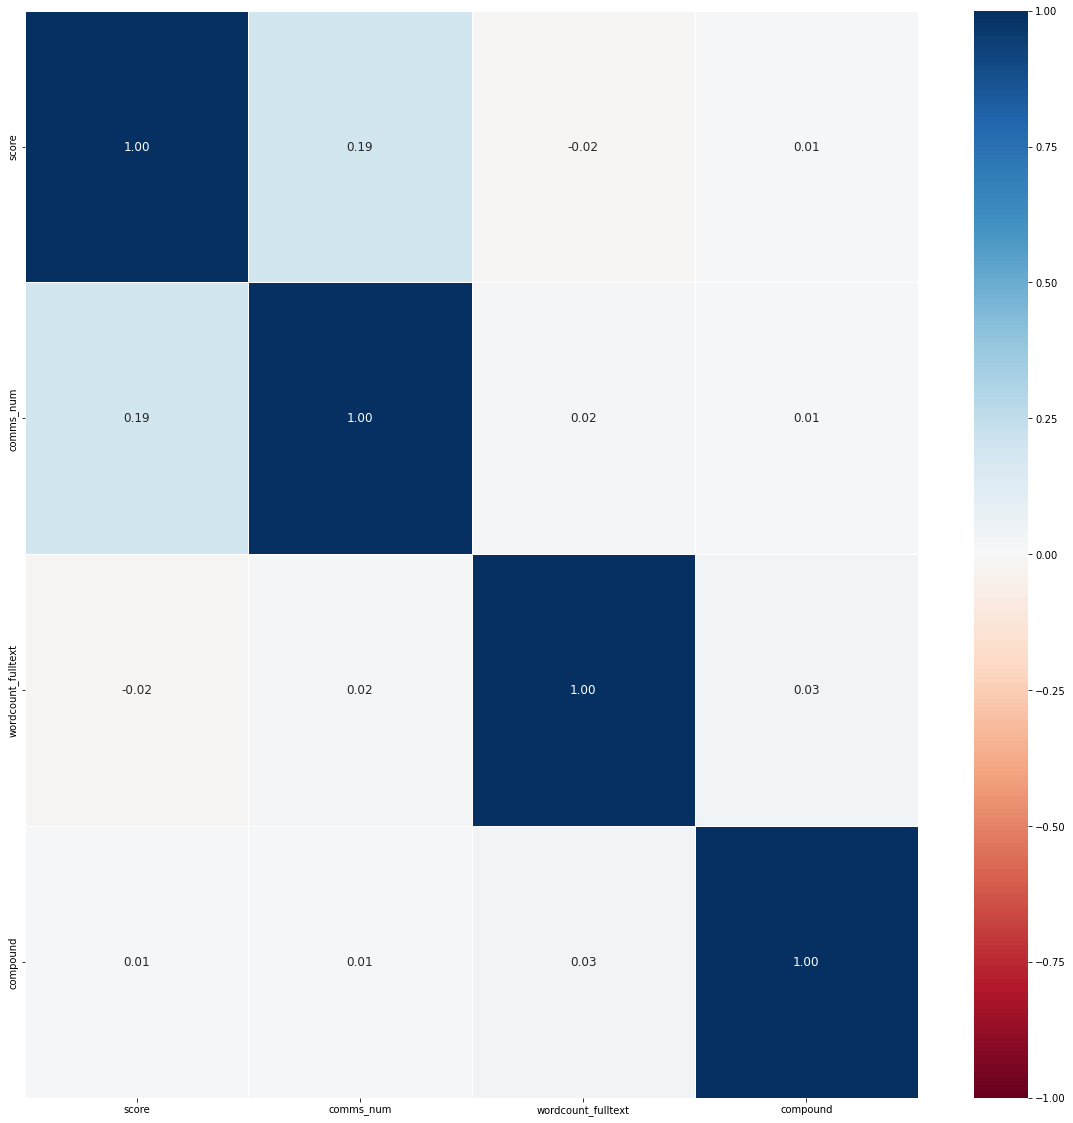

In [44]:
# Correlation Matrix
print(num_data.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(20, 20))
sns.heatmap(num_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 12}, cmap = "RdBu")


Observation: Weak to no correlation between numeric data.

## 3.6 Common Words
> We take a look at what are the most common words used in all the posts on r/WallStreetBets. 
>
> **Note**: This does not include the stock's symbols (E.g. GME)

In [45]:
pat = r'\b(?:{})\b'.format('|'.join(us_tickers))

common_words = pd.DataFrame(df['full_text'].str.replace(pat, '', regex=True))
common_words= pd.DataFrame(Counter(" ".join(common_words['full_text']).split()).most_common(20))
common_words.columns =['Removed_Tinker', 'Counts']
common_words


,Removed_Tinker,Counts
0,not,33074
1,stock,27500
2,buy,24351
3,share,24100
4,gme,23640
5,short,20371
6,m,19311
7,market,19149
8,price,18934
9,like,16709


In [46]:
common_words = common_words[~(common_words['Removed_Tinker'] == 'gme')]
common_words = common_words[~(common_words['Removed_Tinker'] ==  'x200b')]
common_words

,Removed_Tinker,Counts
0,not,33074
1,stock,27500
2,buy,24351
3,share,24100
5,short,20371
6,m,19311
7,market,19149
8,price,18934
9,like,16709
10,company,16538


Text(0, 0.5, 'Counts')

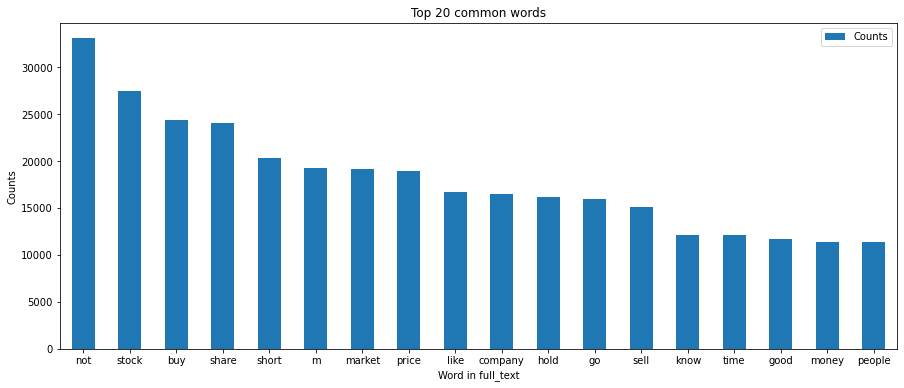

In [47]:
n_head = 20
common_words.sort_values(by='Counts',ascending=False)[:n_head].plot.bar(x='Removed_Tinker',y='Counts',rot=0, figsize=(15,6))

plt.title("Top 20 common words")
plt.xlabel("Word in full_text")
plt.ylabel("Counts")


---

## 3.7 Sentiment polarity score distribution
> The next thing I did was to visualize the sentiments of the post using VADER(Valence Aware Dictionary sEntiment Reasoner). 
>
> To have better accuracy in determining a post sentiment, I updated VADER’s lexicon with a dictionary of positive and negative sentiment stock related words and terms commonly used by users in the subreddit such as YOLO, HODL, TO THE MOON, etc

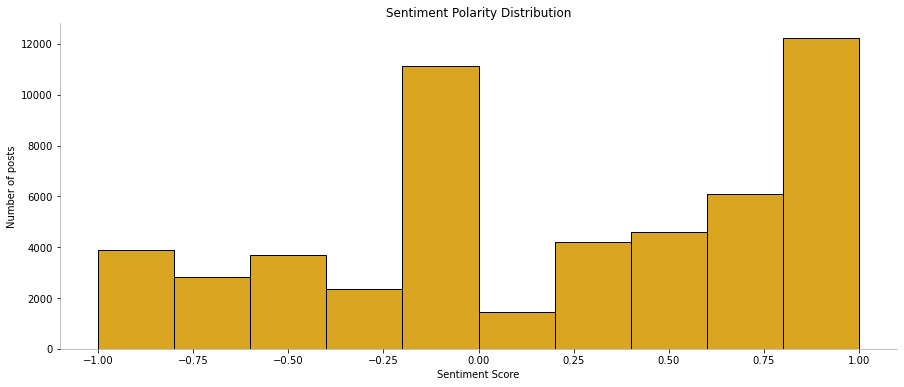

In [48]:
fig = plt.figure(figsize = (15, 6))
 
stock_count  = stock_count.sort_values(by='count',ascending=False)
# creating the bar plot
plt.hist(df["compound"], color ="goldenrod",edgecolor="black")

plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)

plt.xlabel("Sentiment Score")
plt.ylabel("Number of posts")
plt.title("Sentiment Polarity Distribution")
plt.show()


## 3.8 Analysis of most mentioned stocks

> Before proceeding with the next step which is to analyze posts sentiments against stock price and market volume, we would need to first identify stocks that we would focus on using the following methods:

### 3.8.1 Top 20 most discussed stocks
> By sorting out the number of mentions for each stocks, we are trying to find out the the top 20 stocks that were often discussed within the timeeframe. 


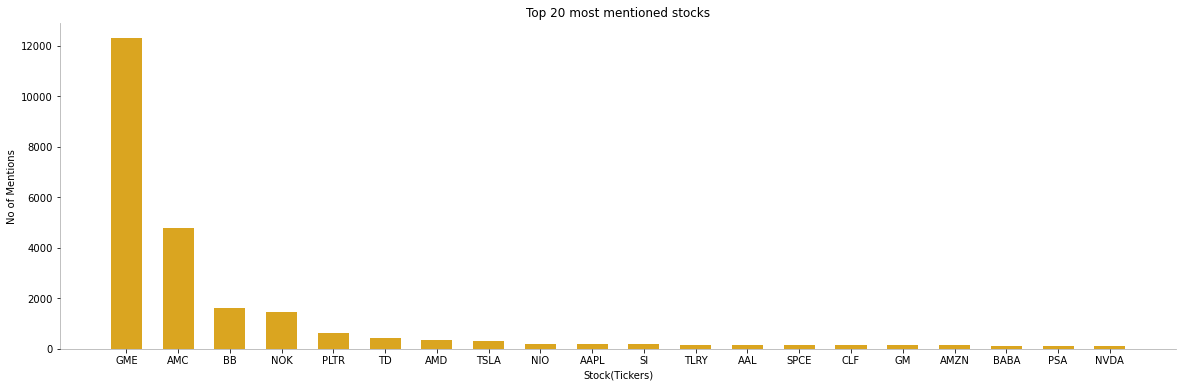

In [49]:
fig = plt.figure(figsize = (20, 6))

#IMPORTANT##### set for all graphs
plt.gca().spines["top"].set_alpha(0.0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)
plt.gca().spines["left"].set_alpha(0.3)
#

stock_count  = stock_count.sort_values(by='count',ascending=False)
# creating the bar plot
plt.bar(stock_count["stock"].head(20), stock_count["count"].head(20), color ='goldenrod',
        width = 0.6)
 
plt.xlabel("Stock(Tickers)")
plt.ylabel("No of Mentions")
plt.title("Top 20 most mentioned stocks")
plt.show()


In [50]:
stock_count.head(5)

,stock,count
0,GME,12306
1,AMC,4803
6,BB,1630
2,NOK,1476
13,PLTR,634


### 3.8.2 Number of mentions by month (top 5 stocks)

> Checking the number of mentions for the top 5 stock per month

In [51]:
df.dtypes

title                  object        
score                  int64         
id                     object        
url                    object        
comms_num              int64         
created                float64       
body                   object        
timestamp              datetime64[ns]
full_text              object        
wordcount_full_text    int64         
stocks                 object        
VS_pos                 float64       
VS_neu                 float64       
VS_neg                 float64       
compound               float64       
sentiment              object        
wordcount_fulltext     int64         
dtype: object

In [52]:
top5 = stock_count['stock'].iloc[0:5].tolist()

first, second, third, fourth, fifth = top5

first = pd.DataFrame(df[df['stocks'].astype(str).str.contains(top5[0])])
second = pd.DataFrame(df[df['stocks'].astype(str).str.contains(top5[1])])
third = pd.DataFrame(df[df['stocks'].astype(str).str.contains(top5[2])])
fourth = pd.DataFrame(df[df['stocks'].astype(str).str.contains(top5[3])])
fifth = pd.DataFrame(df[df['stocks'].astype(str).str.contains(top5[1])])


In [53]:
def mention_by_month(stock):
    stock['month'] = pd.to_datetime(stock.timestamp, format='%Y-%m-%d %H:%M:%S')
    stock['month'] = stock['month'].dt.month_name()

mention_by_month(first)
mention_by_month(second)
mention_by_month(third)
mention_by_month(fourth)
mention_by_month(fifth)


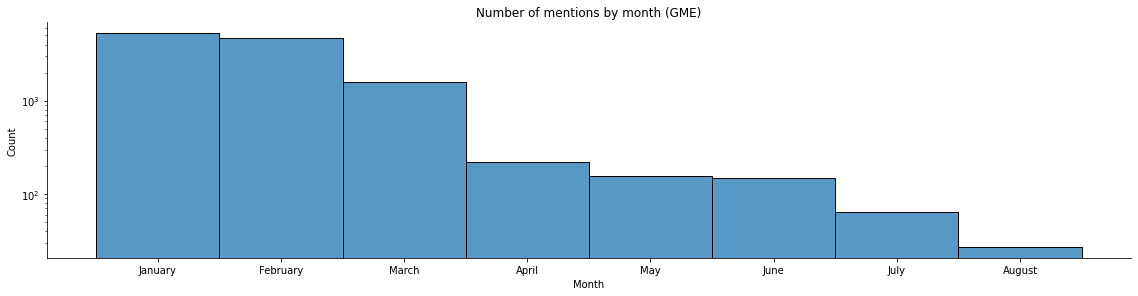

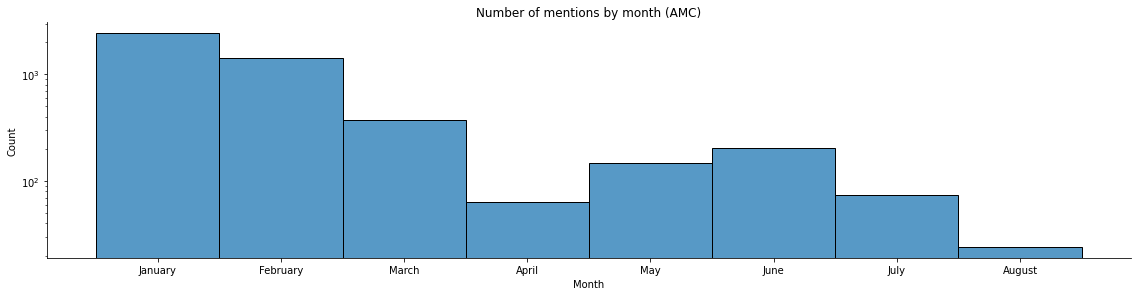

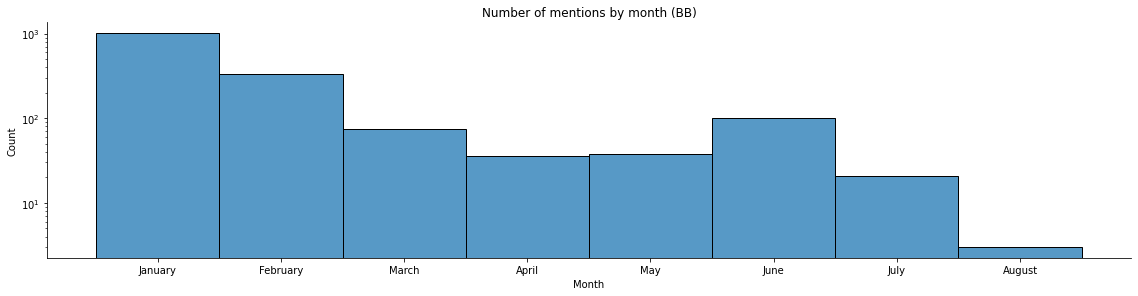

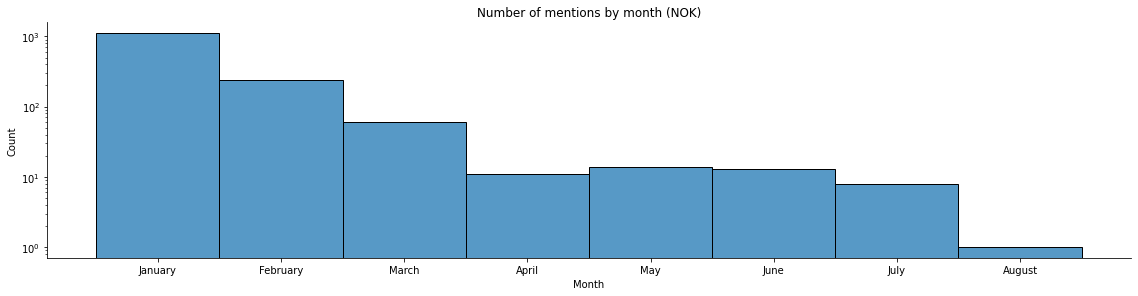

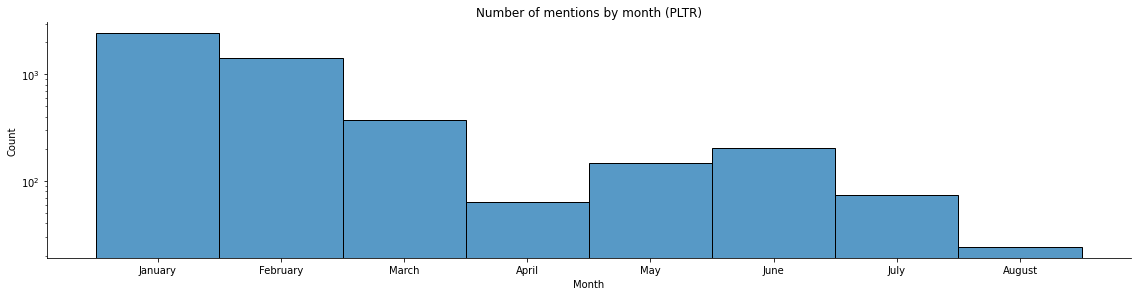

In [54]:
def mention_by_month_plot(stock, name):
    sns.displot(data=stock, kind="hist", x='month', height=4, aspect=4, bins=8)

    plt.title("Number of mentions by month (%s)" % name)
    plt.xlabel("Month")
    plt.ylabel("Count") 
    plt.yscale("log")
    plt.show()
    
mention_by_month_plot(first, top5[0])
mention_by_month_plot(second, top5[1])
mention_by_month_plot(third, top5[2]) 
mention_by_month_plot(fourth, top5[3])
mention_by_month_plot(fifth, top5[4])


### 3.8.3 Compound Score over time (top 5 stocks)

> We plot the mean compound score of the top 5 mentioned stocks by month.

In [55]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [56]:
# Order in months
def month_compound(stock):
    stock_month = pd.DataFrame(stock.groupby('month', as_index=False)['compound'].mean())
    stock_month.index = pd.CategoricalIndex(stock_month['month'], categories=new_order, ordered=True)
    stock_month = stock_month.sort_index().reset_index(drop=True)
    return stock_month

first_month_compound = month_compound(first)
second_month_compound = month_compound(second)
third_month_compound = month_compound(third)
fourth_month_compound = month_compound(fourth)
fifth_month_compound = month_compound(fifth)


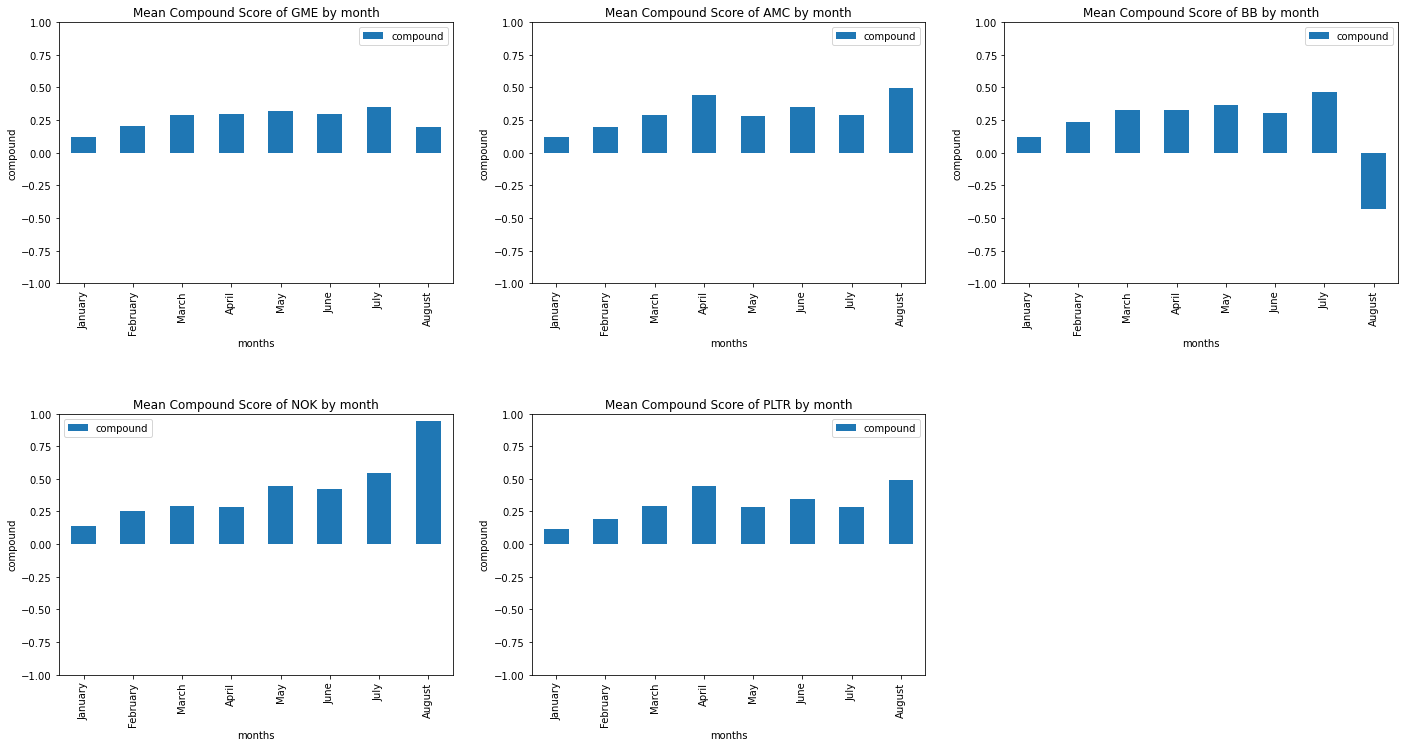

In [57]:
# Mean compound score over time (monthly)
f, axes = plt.subplots(2, 3, figsize=(24, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

def plot(stock_month_compound, axes_coord, stock_name):
    stock_month_compound.plot(ylabel='compound', xlabel='months', kind='bar', ax = axes_coord)
    axes_coord.set_title('Mean Compound Score of %s by month' % stock_name)
    axes_coord.set_xticklabels(stock_month_compound['month'])
    axes_coord.set_ylim(-1,1)

plot(first_month_compound, axes[0,0], top5[0])
plot(second_month_compound, axes[0,1], top5[1])
plot(third_month_compound, axes[0,2], top5[2])
plot(fourth_month_compound, axes[1,0], top5[3])
plot(fifth_month_compound, axes[1,1], top5[4])
f.delaxes(axes[1][2])


Obervations: As you can see from the previous graph that we have plot (3.8.2), even though in the month of January for all top 5 stocks has the highest volume of mentions, the compound mean of the stocks for January for the top 5 stock is going towards neutral sentiments (3.8.3). 

## 3.9 Correlation between Stock Data and our dataframe variables

>Pearson product-moment correlation
>Pearson’s Correlation coefficient is represented as *r*, it measures how strong is the linear association between two continuous variables using the formula:

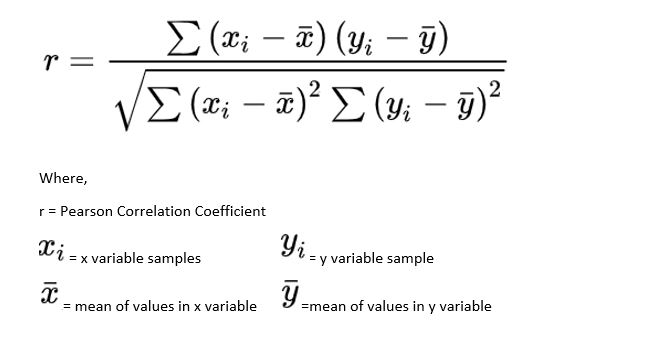

Pearson’s correlation test has two other outputs: **r- value** and **p-value**.

**r-value** is used to find how strong a relationship is between data

Value of *r* ranges from -1 to +1. 

r = 0 indicates *no relation* between the two variables


r > 0 indicates a *positive* relationship between two variables where an increase in the value of one variable increases the value of another variable. 

r < 0 indicates a *negative* relationship between two variables where an increase in the value of one decreases the value of another variable.

**p-value** refers to the output given when performing two-tailed analysis on the *null* and *alternate hypothesis* with a significance threshold of 0.05. The *null hypothesis* will be accepted if the p-value > 0.05, or the *alternate hypothesis* will be accepted if the p-value < 0.05.

*Null Hypothesis*: There is no correlation between post sentiments with the price of the stock

*Alternate Hypothesis*: There is a correlation between post sentiments with the price of the stock

---

In [58]:
fetch_stocks = stock_count["stock"].head().to_list()

In [59]:
df['timestamp']= pd.to_datetime(df['timestamp'])

df["timestamp"] =  df['timestamp'].dt.strftime('%Y-%m-%d')


### 3.9.1 Number of posts vs  trading volume of the stock
> The first hypothesis we will be testing is whether the number of posts related to a particular stock has any form of correlation with its trading volume.
>
> We started off by preprocessing the data first.

In [61]:
def get_stock_data(df, tickers):
    # get start_date and end_date
    #store a dictionary of tickers as key and dataframes as values
    dict_stock_data = {}
    for ticker in tickers:
      start_date =df["timestamp"].min()
      end_date = df["timestamp"].max()
      # get stock data
      stock = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="1d")
      # modify data (date is parked under index and not in the dataframe itself)
      df_date = stock.index.to_frame().reset_index(drop=True)
      stock_data = df_date.merge(stock, on='Date')
      stock_data = stock_data.rename({'Date': 'date', 'Volume': 'volume', 'Close': 'close'}, axis=1)
      stock_data["change"] = stock_data.close.pct_change()
      stock_data["change"] =(stock_data["change"]*100).round(2)
      dict_stock_data[ticker] = stock_data
    return dict_stock_data

date_stock  = get_stock_data(df,fetch_stocks)

In [62]:
def date_iteration(df,tickers):
  dict_date_iterations = {}
  for ticker in tickers:
    #keep all column(stock) containing ticker name
    df_ticker = df[df["stocks"].astype(str).str.contains(ticker)]

    date_count = Counter(df_ticker["timestamp"])


    # convert to df
    y = (pd.DataFrame.from_dict(date_count, orient='index').reset_index()).rename(columns={'index': 'date', 0: 'count'})
    y["date"] = y["date"].apply(pd.to_datetime)  # convert type object to datetime64[ns] to prevent merging error
    dict_date_iterations[ticker] = y
  return dict_date_iterations

date_post = date_iteration(df,fetch_stocks)

In [63]:
from scipy import stats

def stock_corr(date_stock,data_post,tickers):
  final = {}
  corr = {}
  pval = {}
  for ticker in tickers:
    date_stock[ticker] = date_stock[ticker][["date","volume","close","change"]]
    #merge stock_vol with dates with corresponding counts
    tempDf = pd.merge(left=date_post[ticker], right=date_stock[ticker], on='date', how='left')
    tempDf.dropna(inplace=True)

    final[ticker] = tempDf.set_index('date').sort_index()
    # spearman correlation
    corr[ticker], pval[ticker] = stats.spearmanr(tempDf['count'].values,tempDf['volume'].values, nan_policy='omit')

  return final,corr,pval
final,corr,pval = stock_corr(date_stock,date_post,fetch_stocks)

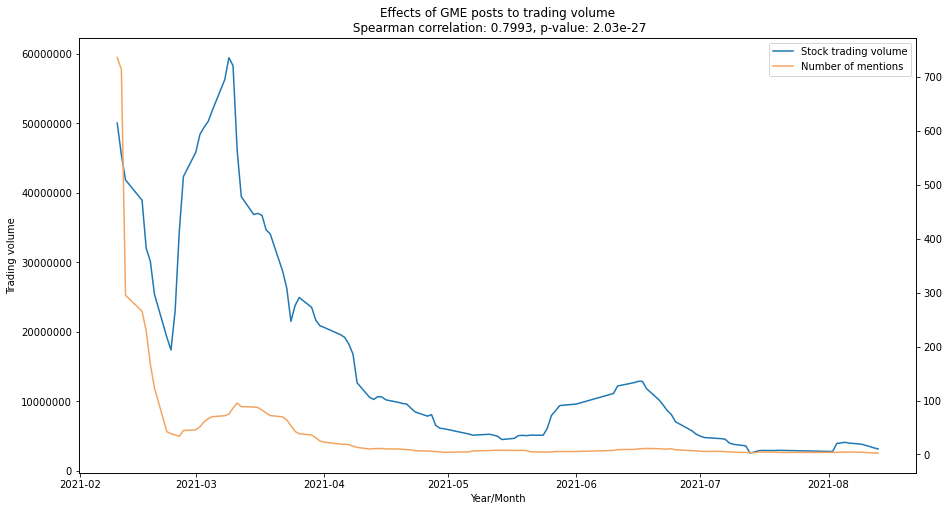

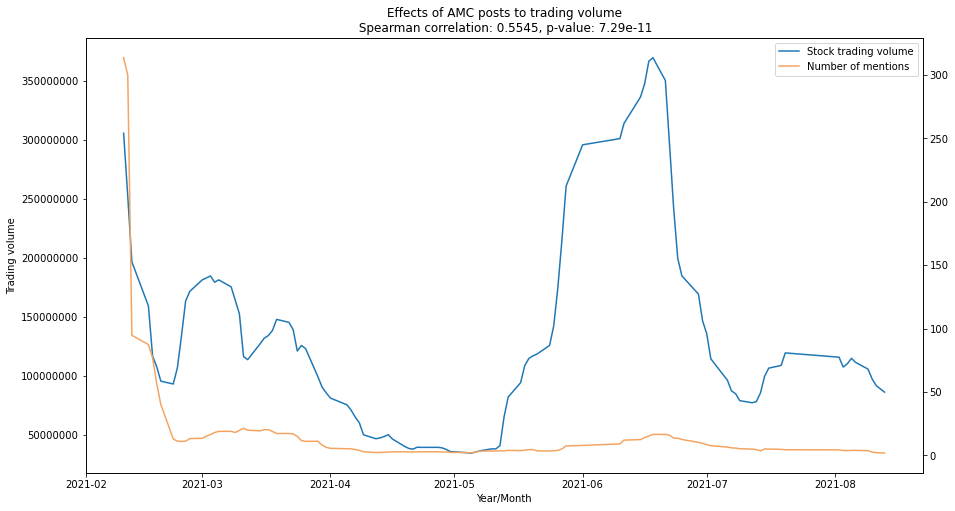

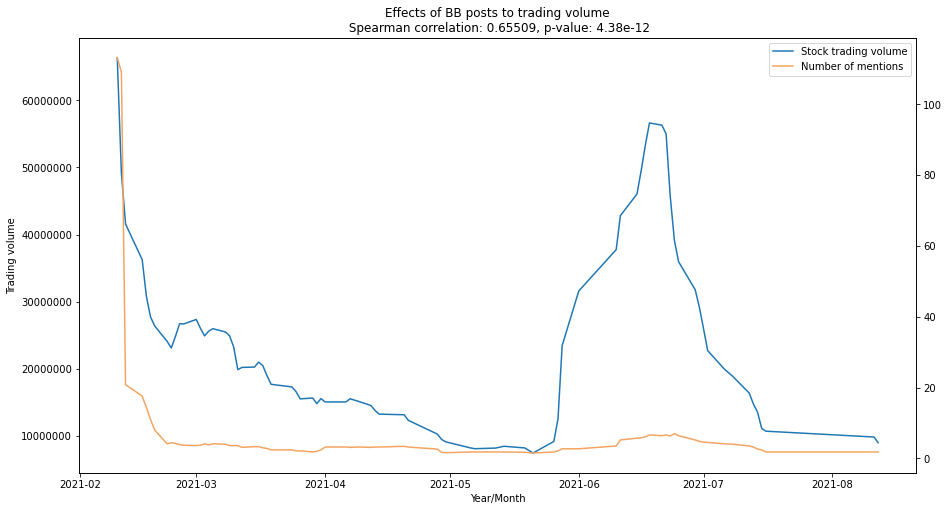

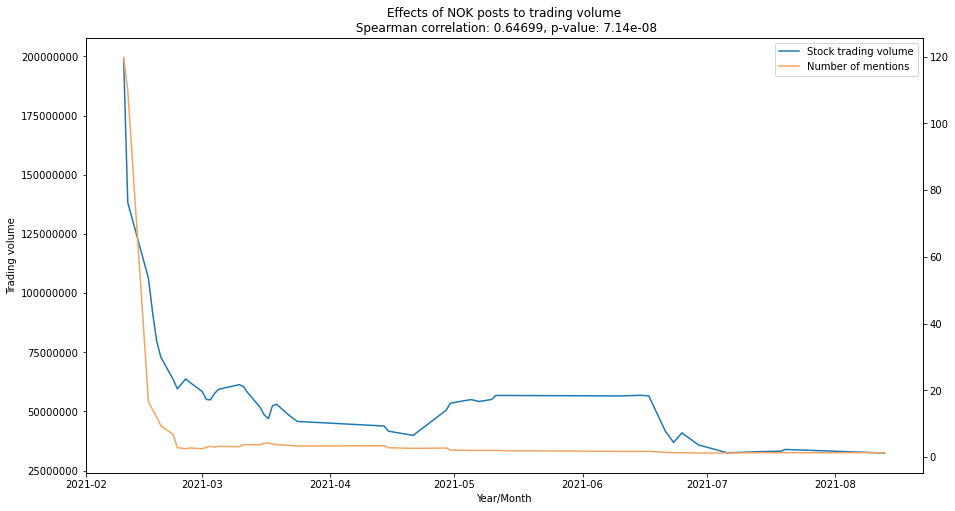

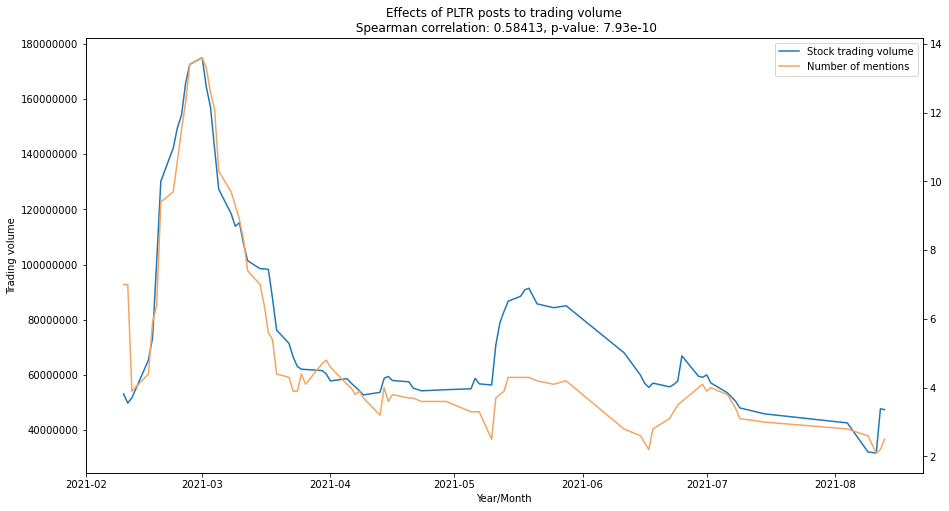

In [64]:
def plotVolumeAndPost(final,tickers,corr,pval):
  # rolling mean
  for ticker in tickers:
    stockvol_rol_mean = final[ticker]["volume"].dropna().rolling(10).mean()
    mention_rol_mean = final[ticker]["count"].dropna().rolling(10).mean()
    # plot
    fig, ax = plt.subplots(figsize= (15,8))


    ax.plot(stockvol_rol_mean.index, stockvol_rol_mean, label="Stock trading volume")
    ax.ticklabel_format(style='plain', axis='y')  # eliminates scientific notification
    ax.set_xlabel("Year/Month")
    ax.set_ylabel("Trading volume")
    ax2 = ax.twinx()
    ax2.plot(mention_rol_mean.index, mention_rol_mean, label="Number of mentions", color="sandybrown")
    if pval[ticker] < 0.0005:
      ax2.set_title("Effects of {} posts to trading volume".format(ticker) + "\n Spearman correlation: {}, p-value: {}".format(round(corr[ticker], 5), format(pval[ticker], '.2e')))
    else:
      ax2.set_title("Effects of {} posts to trading volume".format(ticker) + "\n Spearman correlation: {}, p-value: {}".format(round(corr[ticker], 5), round(pval[ticker], 4)))
    handle, label = ax.get_legend_handles_labels()
    handle2, label2 = ax2.get_legend_handles_labels()
    ax2.legend(handle + handle2, label + label2, loc=0)

    plt.show()

plotVolumeAndPost(final,fetch_stocks,corr,pval)

Observation: Most stocks have a high correlation between Trading volume and the number of post comment and they do fufil the alternate hypothesis 

### 3.9.2 Stock sentiment vs stock price 
> The next hypothesis we will be testing is whether sentiments of posts on a particular stock have any effect on the price of the stock.

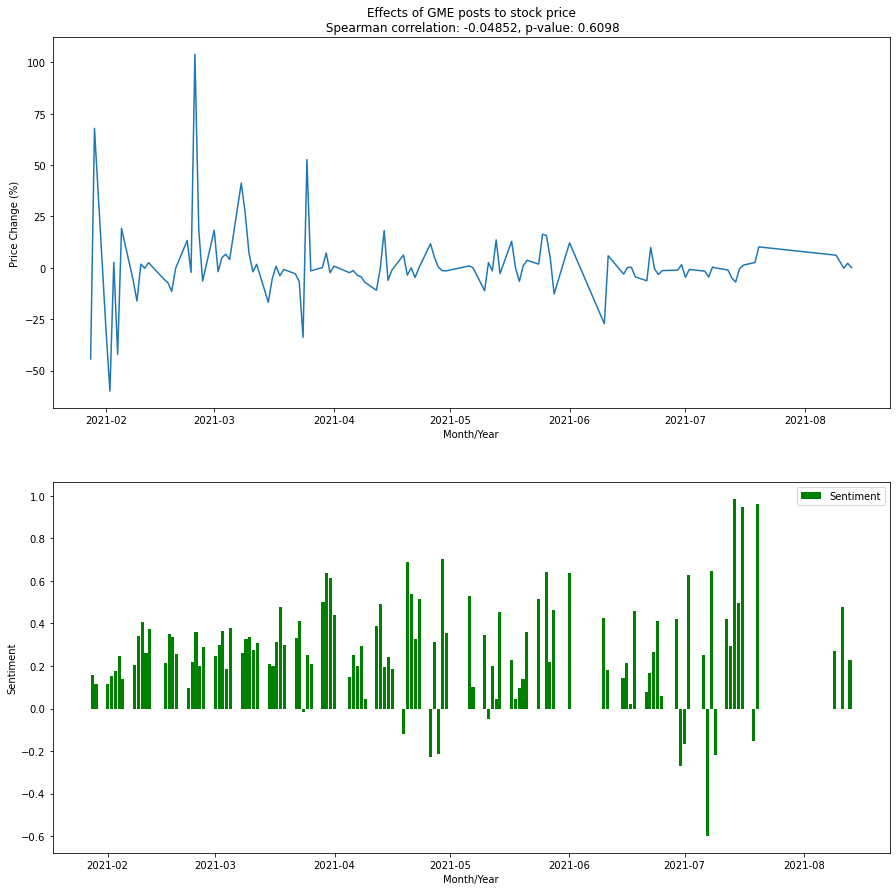

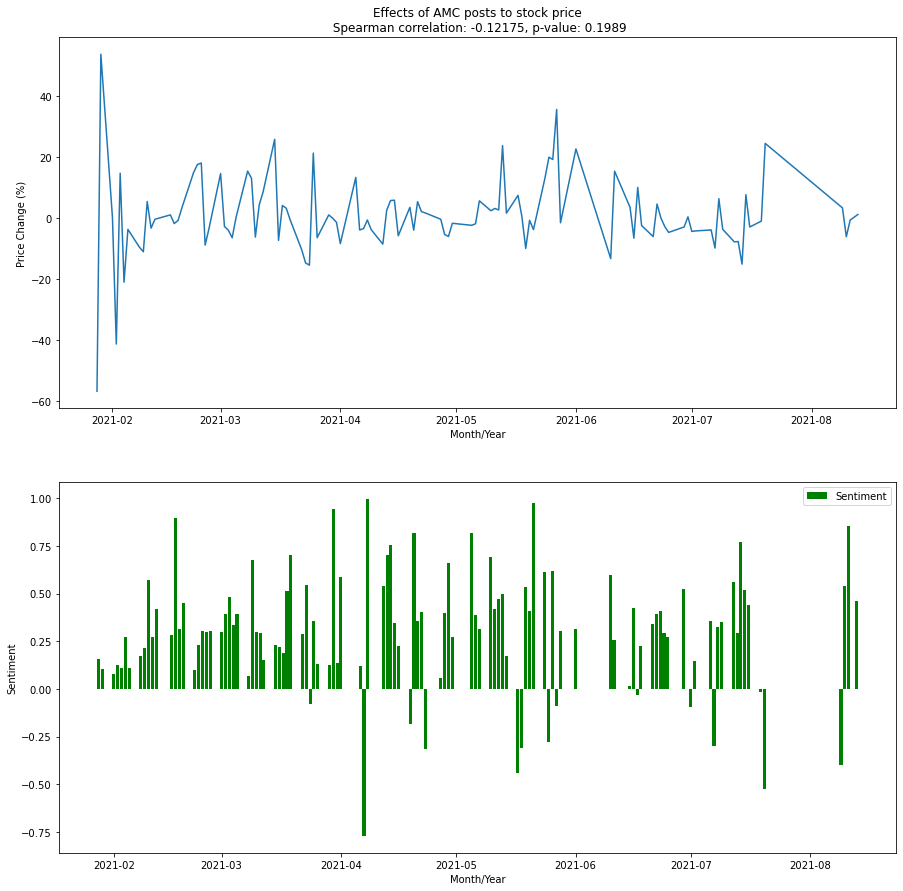

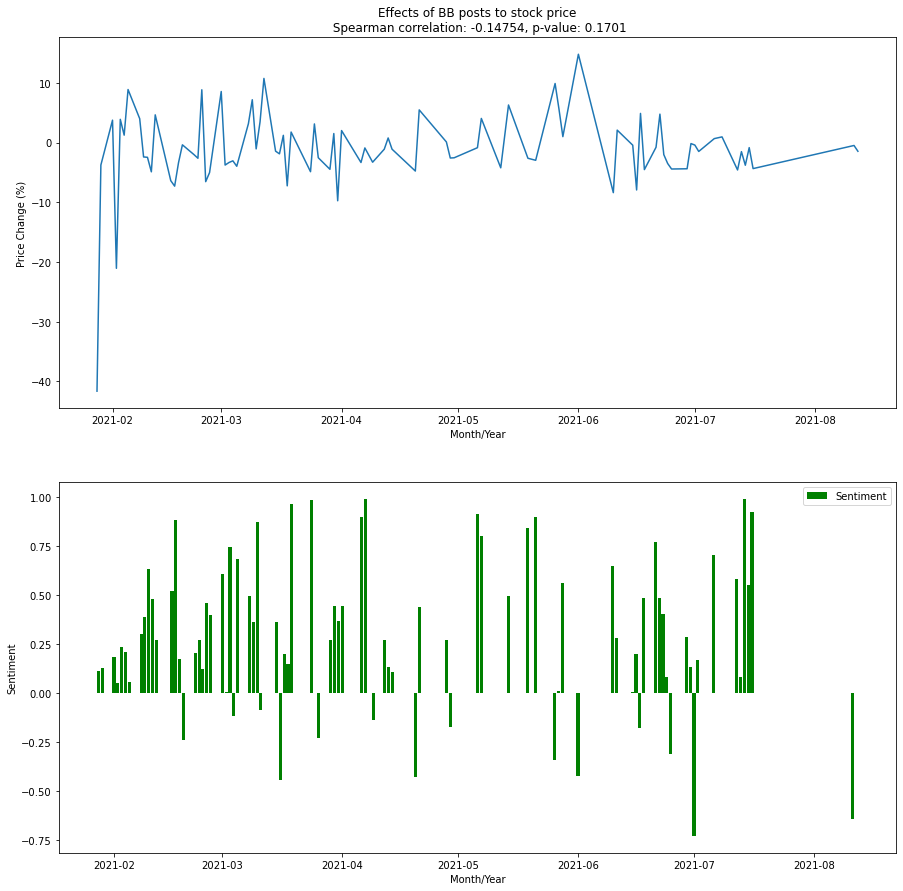

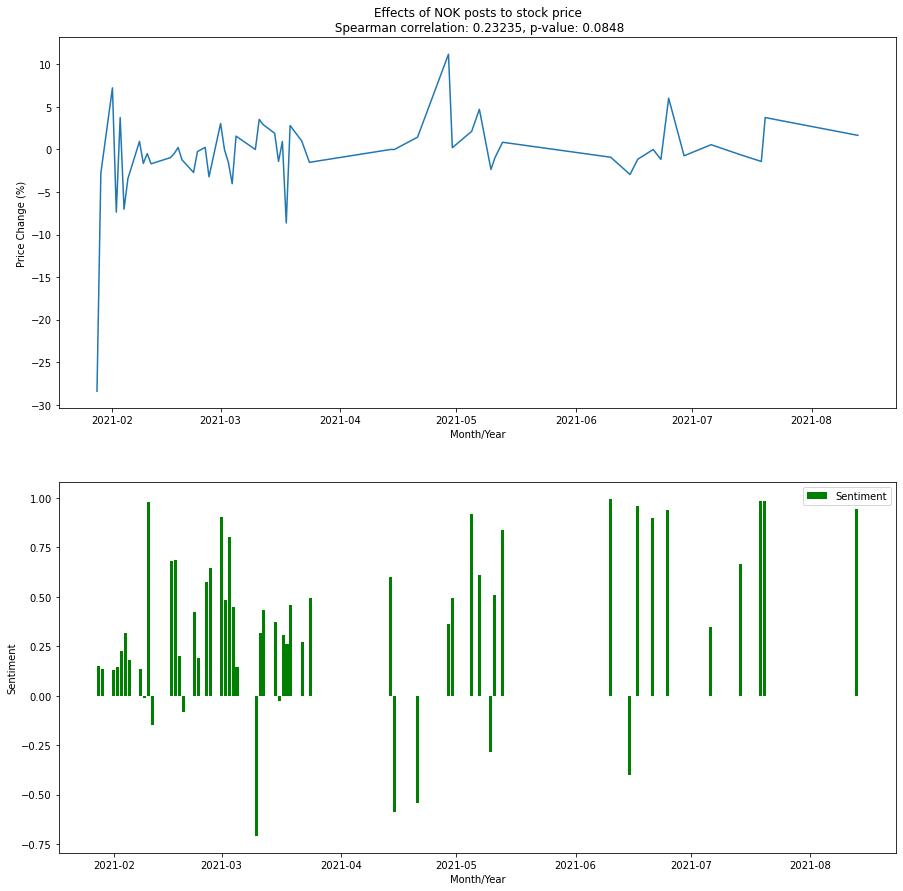

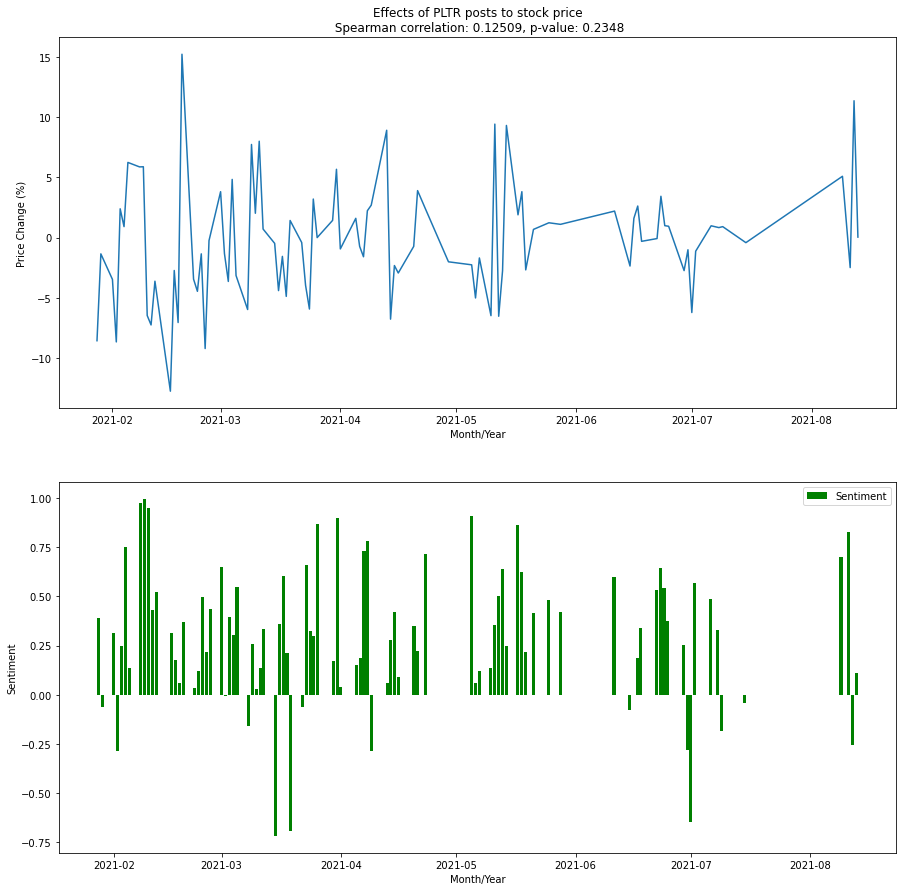

In [65]:
def corrSentimentVsPrice(date_stock,df,tickers):
  #drop all other stocks
  final ={}
  corr = {}
  pval = {}

  for ticker in tickers:
    df_sentiment = df[["timestamp","VS_pos","VS_neu","VS_neg","compound","stocks"]]

    df_sentiment = df[df["stocks"].astype(str).str.contains(ticker)]

    df_sentiment.rename(columns = {'timestamp':'date'}, inplace= True)
    df_sentiment.sort_values(by=['date'], inplace=True)

    df_sentiment['date'] =pd.to_datetime(df_sentiment['date'])
    

    polarity = df_sentiment.groupby('date')["compound"].mean().reset_index()

    final[ticker] = pd.merge(left=polarity, right=date_stock[ticker], how='left', on='date')
    final[ticker] = final[ticker].set_index('date')

    final[ticker].dropna(inplace=True)


    # spearman correlation
    corr[ticker], pval[ticker] = stats.spearmanr(final[ticker]["change"].values, final[ticker]["compound"].values, nan_policy='omit')
  
  return final,corr,pval

def plotSentimentVsPrice(final,tickers,corr,pval):

  for ticker in tickers:
    # plot
    fig, ax = plt.subplots(2,1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax[0].plot(final[ticker]["change"].index, final[ticker]["change"], label="Price Change (%)")
    ax[0].set_xlabel("Month/Year")
    ax[0].set_ylabel("Price Change (%)")
    if pval[ticker] < 0.05:
        ax[0].set_title("Effects of {} posts to stock price".format(ticker) + "\n Spearman correlation: {}, p-value: {}".format(round(corr[ticker], 5), format(pval[ticker], '.2e')))
    else:
        ax[0].set_title("Effects of {} posts to stock price".format(ticker) + "\n Spearman correlation: {}, p-value: {}".format(round(corr[ticker], 5), round(pval[ticker], 4)))

    ax[1].set_xlabel("Month/Year")
    ax[1].bar(final[ticker].index, final[ticker]["compound"], label="Sentiment", color="Green")
    handle, label = ax[1].get_legend_handles_labels()
    ax[1].legend(handle, label, loc=0)
    ax[1].set_ylabel("Sentiment")
    plt.show()

finalSent, corrSent, pvalSent = corrSentimentVsPrice(date_stock,df,fetch_stocks)

plotSentimentVsPrice(finalSent,fetch_stocks,corrSent,pvalSent)


Observation: Most stocks have a little to no correlation between price change and the sentiment score 

# 4.Classification


At first we wanted to used regression to approach this problem, but because the numbers don’t line up cleanly, we’ll instead shift this to a binary classification problem, where the classes will be whether a stock increased or decrease in percentage change daily


Since we’re addressing a classification problem, we’ll use the handy Gradient Boosted Tree. This decision is motivated by the robustness of the algorithm.
Similarly to other tree-based models, the algorithm works well without scaling and on a mixture of binary and continuous features. For Gradient Boosted Trees, we first combine many trees in to a random forest, or a collection of decision trees working together to make a prediction. The “Gradient Boosted” element implies that one tree learns from another in training, rather than trees learning independently and averaging their prediction.

The performance metric we are using is the AUC-ROC curve, it helps us distinguish between our ground truth values and predicted values by measuring true positives, false negatives, true negatives, and false positives of our predictions. The AUC score sits between 0 and 1 with generally the higher, the better prediction performance.

## 4.1 Setting up the machine learning and proof-of-concept

In [66]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], p
    
def pre_process(_X, _y, train_max=None):
    if not train_max:
        train_max = _X.max
    
    # Normalize the features of X
    X = _X / train_max(axis=0)
    
    # Convert stock percent increases (y) to binary "increased or did not increase"
    y = np.where(_y > 0, 1, -1).astype('int')

    return X, y

def tune(_X, _y, model, hyper_params):
    '''
    _X: numpy features from dataframe
    _y: numpy lables from dataframe
    model: sklearn model
    hyper_params: dict of lists of learning_ratess, n_estimators, max_depth, and n_features
    '''
    
    X, y = pre_process(_X, _y)
    
    X_train, y_train, p = unison_shuffled_copies(X[:train_ratio], y[:train_ratio])
    X_test, y_test, _ = unison_shuffled_copies(X[train_ratio:], y[train_ratio:])
    
    peak_acc = 0.0
    clfs = {}

    for lr in hyper_params['learning_rates']:
        for n_est in hyper_params['estimators']:
            for depth in hyper_params['depths']:
                    
                    clf = None

                    if model == 'gb':
                        config = f'{model}_{lr}_{n_est}_{depth}'
                        clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_est, max_depth=depth)
                    elif model == 'rf':
                        if lr != learning_rates[0]: # RandomForestClassifier has no learning rate, skip the loop
                            continue

                        config = f'{model}_{n_est}_{depth}'
                        clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth)

                    clf.fit(X_train, y_train)

                    y_pred = clf.predict(X_test)
                    #score = accuracy_score(y_test, y_pred)
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
                    score = auc(false_positive_rate, true_positive_rate)

                    clfs[config] = {}
                    clfs[config]['clf'] = clf
                    clfs[config]['preds'] = y_pred
                    clfs[config]['acc'] = score

                    if score > peak_acc:
                        peak_acc = score
                        print(f'{config}, auc: {score} (new peak accuracy)')
                    else:
                        print(f'{config}, auc: {score}')

    return clfs, peak_acc

To start off, I will train a model using just learning_rate=0.0001, n_estimators=10000, and max_depth=4. Once trained, I will use that model to predict on both the training data set and the testing data set.

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

rand_seed=42
np.random.seed(rand_seed)

# train_ratio = round(0.80 * finalSentConcat.shape[0])

# _X = finalSentConcat.drop(columns=['date','volume', 'close','change']).to_numpy()
# _y = finalSentConcat['change'].to_numpy()

train_ratio = round(0.80 * finalSent["GME"].shape[0])

_X = finalSent["GME"].drop(columns=['volume', 'close','change']).to_numpy()
_y = finalSent["GME"]['change'].to_numpy()

n_features = _X.shape[1]

learning_rates = [0.1, 0.001, 0.0001]
estimators = [100, 1000, 10000]
depths = [3, 4, 5]
features = range(3, n_features+1)

hyper_params = {
    'learning_rates': learning_rates, 
    'estimators': estimators, 
    'depths': depths, 
    'features': features
}

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes

X_train_demo = X[:train_ratio]
y_train_demo = y[:train_ratio]

X_test_demo = X[train_ratio:]
y_test_demo = y[train_ratio:]

clf = GradientBoostingClassifier(learning_rate=0.0001, n_estimators=10000, max_depth=4)
clf.fit(X_train_demo, y_train_demo)



train_pred = clf.predict(X_train_demo)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_demo, train_pred)
print(f'Train AUC: {auc(false_positive_rate, true_positive_rate)}')
      
y_pred_demo = clf.predict(X_test_demo)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_demo, y_pred_demo)
print(f'Test AUC: {auc(false_positive_rate, true_positive_rate)}')

Train AUC: 0.884710539336962
Test AUC: 0.6349206349206349


In [68]:
X_train, y_train, _ = unison_shuffled_copies(X[:train_ratio], y[:train_ratio])
X_test, y_test, _ = unison_shuffled_copies(X[train_ratio:], y[train_ratio:])

In [69]:
%%time

clf_collection = []
peak_acc_collection = []

for model in ['gb', 'rf']:
    #clfs, accs = tune(_X=_X[20:], _y=_y[20:], model=model, hyper_params=hyper_params)
    clfs, accs = tune(_X=_X, _y=_y, model=model, hyper_params=hyper_params)
    clf_collection.append(clfs)
    peak_acc_collection.append(accs)



gb_0.1_100_3, auc: 0.5634920634920635 (new peak accuracy)
gb_0.1_100_4, auc: 0.619047619047619 (new peak accuracy)
gb_0.1_100_5, auc: 0.619047619047619
gb_0.1_1000_3, auc: 0.619047619047619
gb_0.1_1000_4, auc: 0.619047619047619
gb_0.1_1000_5, auc: 0.619047619047619
gb_0.1_10000_3, auc: 0.619047619047619
gb_0.1_10000_4, auc: 0.619047619047619
gb_0.1_10000_5, auc: 0.619047619047619
gb_0.001_100_3, auc: 0.5793650793650794
gb_0.001_100_4, auc: 0.5595238095238094
gb_0.001_100_5, auc: 0.5793650793650794
gb_0.001_1000_3, auc: 0.6349206349206349 (new peak accuracy)
gb_0.001_1000_4, auc: 0.6349206349206349
gb_0.001_1000_5, auc: 0.5992063492063492
gb_0.001_10000_3, auc: 0.5634920634920635
gb_0.001_10000_4, auc: 0.619047619047619
gb_0.001_10000_5, auc: 0.619047619047619
gb_0.0001_100_3, auc: 0.5
gb_0.0001_100_4, auc: 0.5
gb_0.0001_100_5, auc: 0.5
gb_0.0001_1000_3, auc: 0.5793650793650794
gb_0.0001_1000_4, auc: 0.5595238095238094
gb_0.0001_1000_5, auc: 0.5793650793650794
gb_0.0001_10000_3, auc: 0.

## 4.2 Metrics and Parameter Tuning
>**learning_rate**: this modifies the contribution of each tree
n_estimators: the number of boosting stages, or number of trees that one tree can learn from
>
>**n_estimators**: The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
>
>**max_depth**: the maximum depth of a tree
>
>**min_samples_split**: the minimum number of samples required to split a node (i.e. for a branch-off to occur from that now)
>
>**min_samples_leaf**: the minimum number of samples required to be at a leaf node.

### 4.2.1 Learning Rate






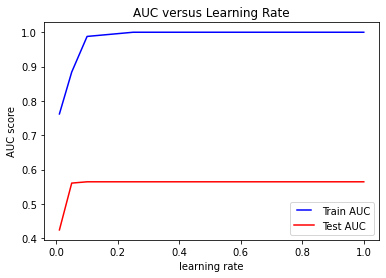

In [70]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for eta in learning_rates:
    clf = GradientBoostingClassifier(learning_rate=eta)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus Learning Rate')
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

### 4.2.2 N_estimators

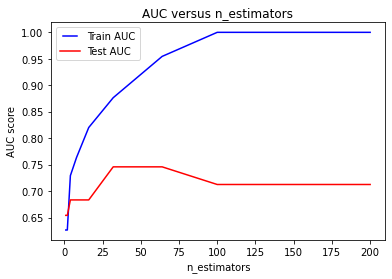

In [71]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for estimator in n_estimators:
    clf = GradientBoostingClassifier(n_estimators=estimator)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus n_estimators')
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

### 4.2.3 max_depth


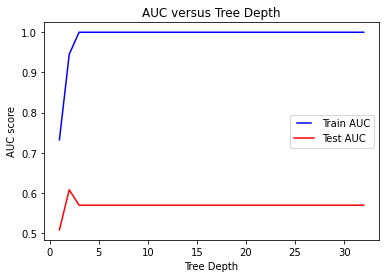

In [72]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for max_depth in max_depths:
    clf = GradientBoostingClassifier(max_depth=max_depth)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus Tree Depth')
plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

### 4.2.4 min_samples_split



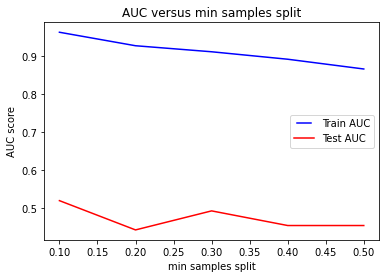

In [73]:
min_samples_splits = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for min_samples_split in min_samples_splits:
    clf = GradientBoostingClassifier(min_samples_split=min_samples_split)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus min samples split')
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

### 4.2.5 min_samples_leaf



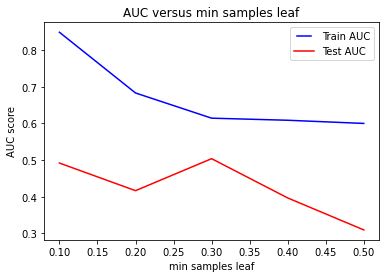

In [74]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_results = []
test_results = []

X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for min_samples_leaf in min_samples_leafs:
    clf = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    clf.fit(x_train, y_train)
    
    train_pred = clf.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('AUC versus min samples leaf')
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

## 4.3 Adjusting to the most optimal parameters

In [75]:
X, y = pre_process(_X, _y) # Normalize X and encode y to binary classes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand_seed)

clf = GradientBoostingClassifier(learning_rate=1, 
                                 n_estimators=60, 
                                 max_depth=14, 
                                 min_samples_split=0.1, 
                                 min_samples_leaf=0.3
                                 )

clf.fit(x_train, y_train)

train_pred = clf.predict(x_train)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'Train AUC: {roc_auc}')

y_pred = clf.predict(x_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'Test AUC: {roc_auc}')

Train AUC: 0.6786727169597278
Test AUC: 0.7424242424242425


After adjusting to the most optimal parameters our model achieved above 0.60 AUC score for both the train and test data. We can say that this model has a decent predictive power when it trying to predict whether a stock will go up or down

---

# 5. Conclusion

In this project, some of the new things we learnt includes Natural Language Processing. We utilised VADER to calculate the sentiment score. We also learnt to utilise the gradient boosting tree for our classification model

We took a closer look at how r/WallStreetBets interacts with the stock market. We reviewed the activity on the subreddit and conducted an analysis to find if there was any significant correlation between sentiment score of stocks and and their price movement. We found that the classification model does provide some predictive power in our dataset. 

To further test our model, it is recommended that we forward test our classification model on real-time market data and test our model on more recent r/wallstreetbets data.
